## Data description
ICD-10 is the 10th revision of the International Statistical Classification of Diseases and Related Health Problems (ICD), a medical classification list by the World Health Organization (WHO). It contains codes for diseases, signs and symptoms, abnormal findings, complaints, social circumstances, and external causes of injury or diseases. Work on ICD-10 began in 1983, became endorsed by the Forty-third World Health Assembly in 1990, and was first used by member states in 1994.

In [1]:
import os
import json
import re
from os.path import join
import pandas as pd
import numpy as np

from string import punctuation
from nltk.stem.snowball import RussianStemmer, SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.svm import SVC
import itertools
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from time import time

from sklearn.datasets import fetch_20newsgroups
from sklearn.ensemble  import RandomForestClassifier
%matplotlib inline

import glob, os
import artm
from artm import score_tracker


[nltk_data] Downloading package punkt to /home/norrilsk/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/norrilsk/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/home/norrilsk/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
RND_SEED = int(time())
specSymb = {"«", "»", "—", "“", "-", "№"}
specSymb =  punctuation + "«»—“-№"
pattern = re.compile("[" + re.escape(specSymb) + "]")

stopEng = stopwords.words('russian')

stemmer_eng = SnowballStemmer("russian")

In [3]:
from bs4 import BeautifulSoup
from collections import Counter
import numpy as np
import pandas as pd

import lxml
import re
from tqdm import tqdm
import requests

main_link = 'https://ru.wikipedia.org'
dict_classes = dict([(cl.get('title'), cl.get('href')) 
    for cl in BeautifulSoup(requests.get(main_link+'/wiki/МКБ-10').text, 'lxml').\
    find('table').findAll('a')])
dict_classes = dict([(cl_name, BeautifulSoup(requests.get(main_link+cl_link).text, 'lxml').\
    findAll('a')) 
    for cl_name, cl_link in dict_classes.items()])
dict_classes = dict([(cl_name, dict([(link.text, link.get('href')) for link in cl_links])) 
    for cl_name, cl_links in dict_classes.items()])
dict_classes = dict([(cl_name, dict([(title.lower(), link) for title, link in cl_links.items() 
        if (link and re.search('^/wiki', link))])) 
    for cl_name, cl_links in dict_classes.items()])





counter = Counter(np.hstack([list(values.keys()) for values in dict_classes.values()]))
uniques = set([key for key in counter if counter[key]==1])

dict_classes = dict([(cl_name, dict([(title, link) for title, link in cl_links.items() 
        if title in uniques])) 
    for cl_name, cl_links in dict_classes.items()])
dict_classes = dict([(cl_name, dict([(title, link) for title, link in cl_links.items() 
        if (len(re.findall('\d', title)) < 1) and (len(title) > 1)])) 
    for cl_name, cl_links in dict_classes.items()])

classes = []
titles = []
texts = []

for cl_name, links in tqdm(dict_classes.items()):
    for title, link in links.items():
        try:
            text = ''.join(np.vectorize(lambda x: x.text)\
                (BeautifulSoup(requests.get(main_link+link).text, 'lxml').findAll('p')))
        except:
            continue
        classes.append(cl_name)
        titles.append(title)
        texts.append(text)



<input>:34: DeprecationWarning: invalid escape sequence \d
<ipython-input-3-dfc08d526e27>:34: DeprecationWarning: invalid escape sequence \d
  if (len(re.findall('\d', title)) < 1) and (len(title) > 1)]))
100%|██████████| 21/21 [04:43<00:00,  7.96s/it]


In [4]:
pd.DataFrame({'class':classes, 'title':titles, 'text':texts}).to_csv('./data/mbk/mbk_10.csv')

In [5]:
def preprocess(text):
    text = text.lower()
    text = re.sub(pattern, '', text)
    tokens = word_tokenize(text)
    tokens_without_nums = filter(lambda x: not x.isdigit(), tokens)  # skip all numbers
    tokens_without_stop = filter(lambda x: x not in stopEng, tokens_without_nums)
    tokens_stem_eng = map(lambda x: stemmer_eng.stem(x), tokens_without_stop)
    
    return " ".join(tokens_stem_eng)

## Roman to arabic

In [6]:

class ToArabic(str):
    def __init__(self, roman):
        roman = self.check_valid(roman)
        keys = ['IV', 'IX', 'XL', 'XC', 'CD', 'CM', 'I', 'V', 'X', 'L', 'C', 'D', 'M']
        to_arabic = {'IV': '4', 'IX': '9', 'XL': '40', 'XC': '90', 'CD': '400', 'CM': '900',
                'I': '1', 'V': '5', 'X': '10', 'L': '50', 'C': '100', 'D': '500', 'M': '1000'}
        for key in keys:
            if key in roman:
                roman = roman.replace(key, ' {}'.format(to_arabic.get(key)))
        self.arabic = sum(int(num) for num in roman.split())

    def check_valid(self, roman):
        roman = roman.upper()
        invalid = ['IIII', 'VV', 'XXXX', 'LL', 'CCCC', 'DD', 'MMMM']
        if any(sub in roman for sub in invalid):
            raise ValueError('Numerus invalidus est: {}'.format(roman))
        return roman

def convert(number):
    num = ToArabic(number)
    return num.arabic


## Load data

In [7]:
%%time
data = pd.read_csv("./data/mbk/mbk_10.csv")

data["text"] = data["text"].apply(preprocess)



CPU times: user 48.5 s, sys: 4 ms, total: 48.5 s
Wall time: 48.6 s


In [8]:
data.head()

,Unnamed: 0,class,title,text
0,0,МКБ-10: Класс I,холера,холе́р дргреч χολή желч ῥέω тек остр кишечн ан...
1,1,МКБ-10: Класс I,паратиф,паратиф дргреч παρά окол тиф групп кишечн инфе...
2,2,МКБ-10: Класс I,брюшной тиф,брюшн тиф остр циклическ протека кишечн антроп...
3,3,МКБ-10: Класс I,сальмонеллезная септицемия,сальмонеллез возбудител котор служат различн в...
4,4,МКБ-10: Класс I,шигеллёз,шигеллез дизентер сборн групп инфекцион заболе...


In [9]:
y = data["class"].values
X = data.text
i = 0
for i in range(len(y)):
    s = y[i].split()
    l = s[-1]
    y[i] = convert(l)
    

In [10]:
print(X[1:5])
print(y[1:5])
y=y.astype('int')

1    паратиф дргреч παρά окол тиф групп кишечн инфе...
2    брюшн тиф остр циклическ протека кишечн антроп...
3    сальмонеллез возбудител котор служат различн в...
4    шигеллез дизентер сборн групп инфекцион заболе...
Name: text, dtype: object
[1 1 1 1]


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y, random_state = RND_SEED)

In [12]:
X_train.shape[0], X_test.shape[0]

(819, 205)

In [13]:
print(y_train[1:5])

[ 4  4 11 12]


In [14]:
X_train.head()

1023    акцентуа́ц акцентуа́ц хара́ктер акцентуа́ц ли́...
471     боле́зн ха́нтер синдро́м ха́нтер англ hunter s...
458     воскови́дн липофусцино́з нейро́н англ ncl neur...
957     гепаторена́льн синдро́м патологическ состоян в...
993     онихоли́зис отслоен ногт мягк ткан пальц образ...
Name: text, dtype: object

## Define vectorizer and model

In [15]:
vect_count = CountVectorizer(binary=True)
vect_tfidf = TfidfVectorizer()
vect_hash = HashingVectorizer()


In [16]:
logreg = LogisticRegression(C=1, solver="liblinear")  
randomforest = RandomForestClassifier()
svm = SVC()

In [17]:
def plot_roc_auc(y_score, y_test):
    fpr, tpr, _ = metrics.roc_curve(y_test, y_score)
    roc_auc = metrics.auc(fpr, tpr)
    f1 = plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc, linewidth=3)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    plt.close()

In [18]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    figure(figsize=(len(classes), len(classes)), dpi=100)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
   
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [19]:
def fit_model(X_train, X_test, y_train, y_test, model, vectorizer):
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    precision = metrics.precision_score(y_test, y_pred, average ="micro")
    recall = metrics.recall_score(y_test, y_pred, average ="micro")
    accuracy = accuracy_score(y_test, y_pred)
    authors = sorted(set(y_test))
    cm = confusion_matrix(y_test, y_pred, labels = authors)
    plot_confusion_matrix(cm, classes=authors, normalize=True,
                      title='Normalized confusion matrix')
    print("accuracy %s\n" % ( accuracy))

    #y_score = model.decision_function(X_test)

Normalized confusion matrix


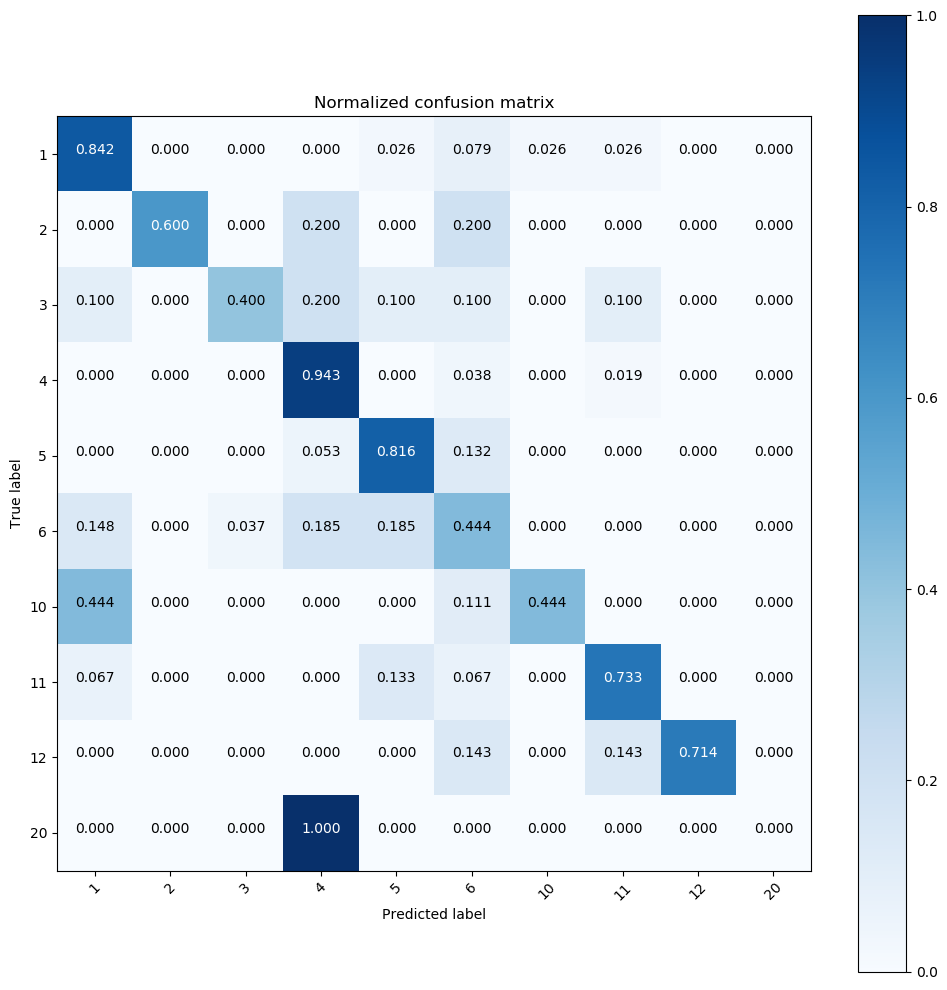

accuracy 0.7414634146341463

CPU times: user 7.1 s, sys: 728 ms, total: 7.83 s
Wall time: 4.28 s


In [20]:
%%time
fit_model(X_train, X_test, y_train, y_test, logreg, vect_count)

Normalized confusion matrix


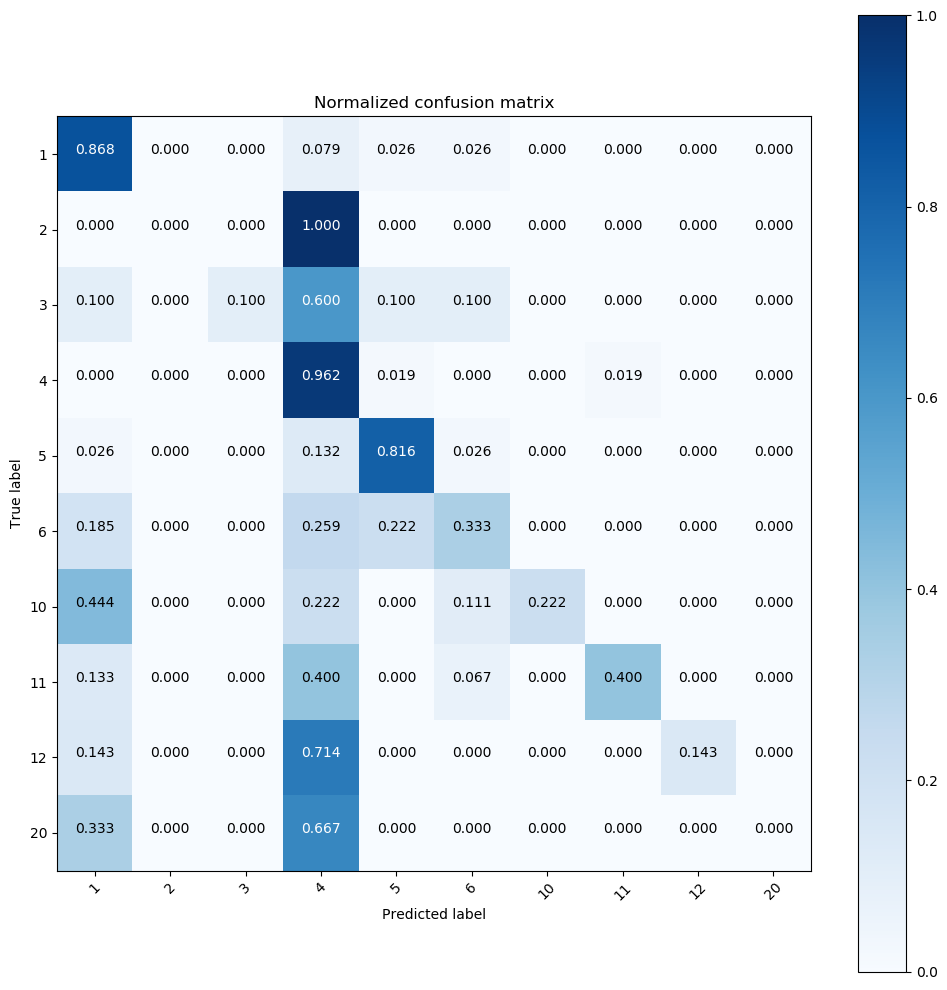

accuracy 0.6536585365853659

CPU times: user 2.91 s, sys: 692 ms, total: 3.6 s
Wall time: 2.01 s


In [21]:
%%time
fit_model(X_train, X_test, y_train, y_test, logreg, vect_tfidf)

Normalized confusion matrix


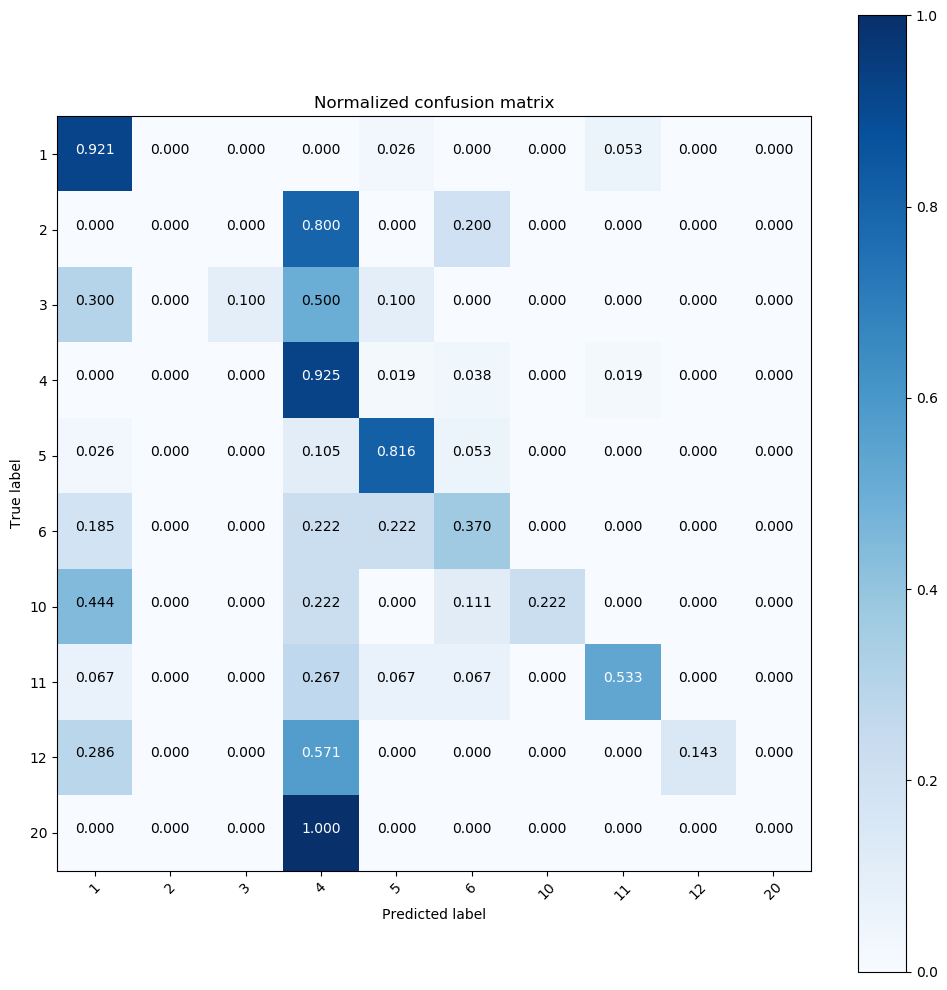

accuracy 0.6682926829268293

CPU times: user 12.5 s, sys: 1.5 s, total: 14 s
Wall time: 7.29 s


In [22]:
%%time
fit_model(X_train, X_test, y_train, y_test, logreg, vect_hash)

## Learn with vowpal wabbit

In [23]:
def to_vw_format(document, label=None):
    return str(label or '') + ' |text ' + ' '.join(re.findall('\w{3,}', document.lower())) + '\n'


<input>:2: DeprecationWarning: invalid escape sequence \w
<ipython-input-23-81aeecabf5cf>:2: DeprecationWarning: invalid escape sequence \w
  return str(label or '') + ' |text ' + ' '.join(re.findall('\w{3,}', document.lower())) + '\n'


In [24]:
with open("." +'/icd10_train_mult.vw', 'w') as vw_train_data:
    for text, target in zip(X_train, y_train):
        vw_train_data.write(to_vw_format(text, target))
with open("." +'/icd10_test_mult.vw', 'w') as vw_test_data:
    for text in X_test:
        vw_test_data.write(to_vw_format(text))

In [25]:
%%time

!vw --oaa 21 ./icd10_train_mult.vw \
-f ./icd10_model_mult.vw --loss_function=hinge

final_regressor = ./icd10_model_mult.vw
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = ./icd10_train_mult.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0       21        1      424
1.000000 1.000000            2            2.0        4       21      221
0.750000 0.500000            4            4.0       11        4      117
0.750000 0.750000            8            8.0        5       21      217
0.750000 0.750000           16           16.0        5        4     3937
malformed example!
words.size() = 165
0.718750 0.687500           32           32.0        4       11      458
0.671875 0.625000           64           64.0        5        4      680
0.531250 0.390625          128          128.0        6        6      122
0.429688 0.328125          256          256.0      

In [26]:
%%time
!vw -i ./icd10_model_mult.vw -t \
-d ./icd10_test_mult.vw \
-p ./icd10_test_predictions_mult.txt

only testing
predictions = ./icd10_test_predictions_mult.txt
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = ./icd10_test_mult.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0  unknown       10      386
1.000000 1.000000            2            2.0  unknown       12      243
1.000000 1.000000            4            4.0  unknown        4      197
1.000000 1.000000            8            8.0  unknown        6      114
1.000000 1.000000           16           16.0  unknown        5     1126
malformed example!
words.size() = 2730
1.000000 1.000000           32           32.0  unknown        5      766
1.000000 1.000000           64           64.0  unknown        4      408
1.000000 1.000000          128          128.0  unknown        5      386

finished run
number of exampl

In [28]:
with open('./icd10_test_predictions_mult.txt') as pred_file:
    test_prediction_mult = [float(label) 
                            for label in pred_file.readlines()]

In [29]:
accuracy_score(y_test, test_prediction_mult)

0.7219512195121951

In [30]:
print(classification_report(y_test, test_prediction_mult))

             precision    recall  f1-score   support

          1       0.66      0.82      0.73        38
          2       1.00      1.00      1.00         5
          3       0.71      0.50      0.59        10
          4       0.90      0.85      0.87        53
          5       0.60      0.82      0.69        38
          6       0.53      0.37      0.43        27
         10       0.86      0.67      0.75         9
         11       0.73      0.53      0.62        15
         12       1.00      1.00      1.00         7
         20       0.00      0.00      0.00         3

avg / total       0.72      0.72      0.71       205



/home/norrilsk/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## BIGARTM

In [32]:
%%time
!rm -rf ./batches_test/ ./batches_train/ ./bigartm.*
doc = -1
def to_vw_format_rtm(document, label,type="train"):
    global doc
    doc = doc +1
    if (type == "train"):
        return str("doc_" + str(doc)) + ' |@raw_text ' + ' '.join(re.findall('\w{3,}', document.lower()))\
            + ' |@origin ' + str(label or "0") + "ss"+'\n'
    elif (type == "test"):
        return str("doc_" + str(doc)) + ' |@raw_text ' + ' '.join(re.findall('\w{3,}', document.lower()))\
            + '\n'
    elif (type == "labels"):
        return str("doc_" + str(doc)) + ' |@origin '+ str(label or "0")+"ss" +'\n'

    
doc = -1
with open("." +'/icd10_train_artm.vw', 'w') as vw_train_data:
    for text, target in zip(X_train, y_train):
        vw_train_data.write(to_vw_format_rtm(text, target, type = "train"))
doc1 = doc
with open("." +'/icd10_test_artm.vw', 'w') as vw_test_data:
    for text, target in zip(X_test, y_test):
        vw_test_data.write(to_vw_format_rtm(text, target, type = "test"))
doc = doc1
with open("." + '/icd10_labels_artm.vw', 'w') as vw_labels_data:
    for text, target in zip(X_test, y_test):
        vw_labels_data.write(to_vw_format_rtm(text, target, type = "labels"))

SHOULD_RUN_ON_A_SMALL_SUBSET = False

def get_true_labels(vw_filename):
    res = {}
    with open(vw_filename, "r", encoding="utf8") as f:
        for line in f:
            contents = line.split("|")
            doc, _, part = line.partition("|")
            modality_name, _, data = part.partition(" ")
            modality_name = modality_name.strip()
            if modality_name == "@origin":
                res[doc.strip()] = data.strip()
    return res

def get_ys(y_true_dict, y_pred_df):
    y_true = []
    y_pred = []
    for doc, answer in y_true_dict.items():
        y_true.append(answer)
        y_pred.append(y_pred_df[doc].argmax())
    return y_true, y_pred


def read_collection(target_folder, vw_name):
    if len(glob.glob(os.path.join(target_folder, '*.batch'))) < 1:
        batch_vectorizer = artm.BatchVectorizer(
            data_path=vw_name,
            data_format='vowpal_wabbit',
            target_folder=target_folder)
    else:
        batch_vectorizer = artm.BatchVectorizer(
            data_path=target_folder,
            data_format='batches')

    dictionary = artm.Dictionary()
    dict_path = os.path.join(target_folder, 'dict.dict')

    if not os.path.isfile(dict_path):
        dictionary.gather(data_path=batch_vectorizer.data_path)
        dictionary.save(dictionary_path=dict_path)

    dictionary.load(dictionary_path=dict_path)
    return batch_vectorizer, dictionary

# read train data
vw_filename = "./icd10_train_artm.vw"
batch_vectorizer, dictionary = read_collection("batches_train", vw_filename)

import warnings
warnings.filterwarnings("ignore")
# build a simple topic model
N_TOPICS = 22

model = artm.ARTM(
    topic_names=['topic {}'.format(i) for i in range(N_TOPICS)],
    theta_columns_naming = 'title',
    regularizers=[], 
    scores=[
        artm.TopTokensScore(name='TopTokensScore', num_tokens=14, class_id="@raw_text"),
    ],
    class_ids={'@raw_text': 1.0, '@origin': 1.0}
)


model.initialize(dictionary=dictionary)

model.num_document_passes = 10 
num_collection_passes = 100

# fit this model on a train dataset

model.fit_offline(
    batch_vectorizer=batch_vectorizer,
    num_collection_passes=num_collection_passes
)
# let's look at most probable words of each topic
print("Tokens:")
top_tokens = model.score_tracker['TopTokensScore'].last_tokens
for topic_name in model.topic_names:
    print(topic_name + ': ')
    print(top_tokens[topic_name])

# read the test dataset
vw_filename = "./icd10_test_artm.vw"
batch_vectorizer, dictionary = read_collection("batches_test", vw_filename)

# get distribution Pr(label | document) for test dataset
result = model.transform(batch_vectorizer=batch_vectorizer, predict_class_id="@origin")
#print(result)
# read true labels
vw_filename = "./icd10_labels_artm.vw"
y_true_dict = get_true_labels(vw_filename)

# convert distribution to the point estimate
# making sure that numbering of documents is consistent 
y_true, y_predicted = get_ys(y_true_dict, result)

# measure classification accuracy
print('accuracy_score :')
print(accuracy_score(y_true, y_predicted))


<input>:9: DeprecationWarning: invalid escape sequence \w
<unknown>:9: DeprecationWarning: invalid escape sequence \w
/home/norrilsk/.local/lib/python3.6/site-packages/artm/batches_utils.py:170: DeprecationWarning: PyUnicode_AsEncodedObject() is deprecated; use PyUnicode_AsEncodedString() to encode from str to bytes or PyCodec_Encode() for generic encoding
  parser_config.target_folder = target_f
/home/norrilsk/.local/lib/python3.6/site-packages/artm/master_component.py:340: DeprecationWarning: PyUnicode_AsEncodedObject() is deprecated; use PyUnicode_AsEncodedString() to encode from str to bytes or PyCodec_Encode() for generic encoding
  gather_args.dictionary_target_name = dictionary_target_name


Tokens:
topic 0: 
['желудк', 'слизист', 'кокаин', 'хроническ', 'заболеван', 'болезн', 'котор', 'явля', 'случа', 'экзем', 'остр', 'язвен', 'оболочк', 'язв']
topic 1: 
['котор', 'год', 'полов', 'человек', 'случа', 'кож', 'чесотк', 'явля', 'такж', 'кист', 'част', 'вид', 'лечен', 'заболеван']
topic 2: 
['диабет', 'сахарн', 'инсулин', 'тип', 'лечен', 'заболеван', 'явля', 'котор', 'глюкоз', 'развит', 'ткан', 'поджелудочн', 'кров', 'случа']
topic 3: 
['котор', 'днк', 'явля', 'белк', 'аминокислот', 'хлор', 'кислот', 'молекул', 'клетк', 'такж', 'организм', 'процесс', 'образ', 'реакц']
topic 4: 
['расстройств', 'котор', 'люд', 'могут', 'друг', 'лечен', 'такж', 'част', 'явля', 'так', 'дет', 'пациент', 'заболеван', 'симптом']
topic 5: 
['бол', 'головн', 'мозг', 'нарушен', 'давлен', 'лечен', 'случа', 'связа', 'возника', 'заболеван', 'больн', 'приступ', 'явля', 'част']
topic 6: 
['вирус', 'препарат', 'котор', 'такж', 'заболеван', 'лечен', 'герпес', 'инфекц', 'явля', 'энцефалит', 'форм', 'заражен', '